# Library

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init


In [143]:
# Load csv dataset
dataset = pd.read_csv('/Users/catherine/Desktop/diabetes.csv')
# Drop missing values
dataset = dataset.dropna()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 759 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Outcome                   759 non-null    int64  
 1   Pregnancies               759 non-null    float64
 2   Glucose                   759 non-null    float64
 3   BloodPressure             759 non-null    float64
 4   SkinThickness             759 non-null    float64
 5   Insulin                   759 non-null    float64
 6   BMI                       759 non-null    float64
 7   DiabetesPedigreeFunction  759 non-null    float64
 8   Age                       759 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 59.3 KB


In [144]:
# Split the data into features and target
X = dataset.drop('Outcome', axis=1).to_numpy()
y = dataset['Outcome'].to_numpy()
y[y == -1] = 0

# Assuming X is your feature matrix and y is the target vector
num_samples = X.shape[0]

# Define the size of each split
train_size = int(0.7 * num_samples)  # 70% of the data
val_size = int(0.15 * num_samples)  # 15% of the data

# Split the data
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # For classification tasks with CrossEntropyLoss

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)  # For classification tasks with CrossEntropyLoss

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)  # For classification tasks with CrossEntropyLoss
 

# Mutiple(Two) layers model Perceptron

In [163]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate), 
            nn.Linear(hidden_dim, hidden_dim),  
            nn.ReLU(),
            nn.Dropout(dropout_rate), 
            nn.Linear(hidden_dim, output_dim)
        )

        # Initialization
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
        
    def forward(self, x):
        return self.layers(x)

In [189]:
if __name__ == '__main__':
    # Set fixed random number seed
    torch.manual_seed(420)
    
    # Initialize model, criterion, and optimizer
    input_dim = X_train.shape[1]
    hidden_dim = 49
    learning_rate = 0.0085
    output_dim = 2
    dropout_rate = 0.05
    model = MLP(input_dim, hidden_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    weight_decay = 0.007
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Initialize a DataFrame to store the results
    results_df = pd.DataFrame(columns=['Epoch', 'Loss', 'Train Accuracy', 'Val Accuracy'])
    
# Run the training loop
train_accuracies, val_accuracies, losses = [], [], []  # Initialize lists
for epoch in range(20):  
    print(f'Starting epoch {epoch+1}')
    
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Add L1 regularization
    l1_reg = torch.tensor(0.).to(X_train_tensor.device)
    for param in model.parameters():
        l1_reg += torch.norm(param, 1)
    loss += l1_regularization_strength * l1_reg
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Store the loss value
    losses.append(loss.item())
    
    # Calculate and store Training Accuracy
    with torch.no_grad():
        _, train_predicted = torch.max(outputs, 1)
        train_accuracy = (train_predicted == y_train_tensor).float().mean().item()
        train_accuracies.append(train_accuracy)
        
        # Calculate and store Validation Accuracy
        val_outputs = model(X_val_tensor)
        _, val_predicted = torch.max(val_outputs, 1)
        val_accuracy = (val_predicted == y_val_tensor).float().mean().item()
        val_accuracies.append(val_accuracy)
        
    # Append the results to the DataFrame
    results_df = pd.concat([results_df, pd.DataFrame({
        'Epoch': [epoch + 1],
        'Loss': [loss.item()],
        'Train Accuracy': [train_accuracy],
        'Val Accuracy': [val_accuracy]
    })], ignore_index=True)
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}, Train Accuracy: {train_accuracy}, Val Accuracy: {val_accuracy}')


Starting epoch 1
Epoch 1, Loss: 1.0867819786071777, Train Accuracy: 0.4124293923377991, Val Accuracy: 0.389380544424057
Starting epoch 2
Epoch 2, Loss: 1.082763433456421, Train Accuracy: 0.4030131697654724, Val Accuracy: 0.4159291982650757
Starting epoch 3
Epoch 3, Loss: 1.078890085220337, Train Accuracy: 0.43879473209381104, Val Accuracy: 0.4690265357494354
Starting epoch 4
Epoch 4, Loss: 1.0763624906539917, Train Accuracy: 0.4312617778778076, Val Accuracy: 0.48672565817832947
Starting epoch 5
Epoch 5, Loss: 1.0709114074707031, Train Accuracy: 0.47080978751182556, Val Accuracy: 0.5398229956626892
Starting epoch 6
Epoch 6, Loss: 1.0680549144744873, Train Accuracy: 0.478342741727829, Val Accuracy: 0.5752212405204773
Starting epoch 7
Epoch 7, Loss: 1.0630412101745605, Train Accuracy: 0.508474588394165, Val Accuracy: 0.5398229956626892
Starting epoch 8
Epoch 8, Loss: 1.0610989332199097, Train Accuracy: 0.5404896140098572, Val Accuracy: 0.6725663542747498
Starting epoch 9
Epoch 9, Loss: 1.

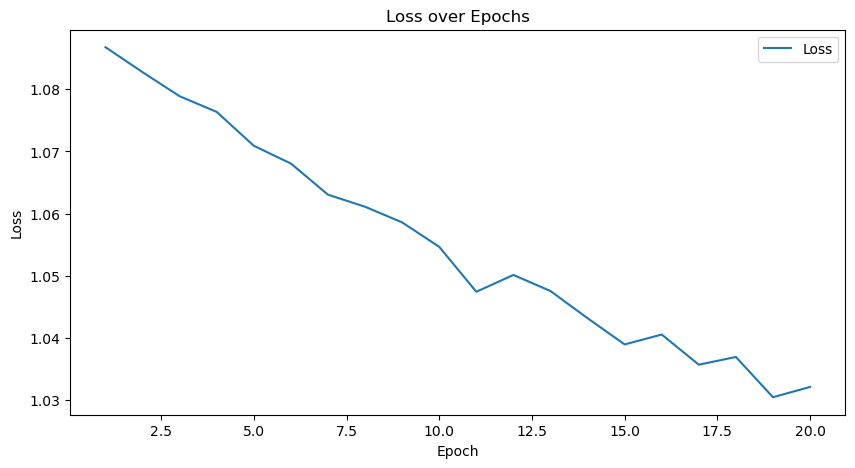

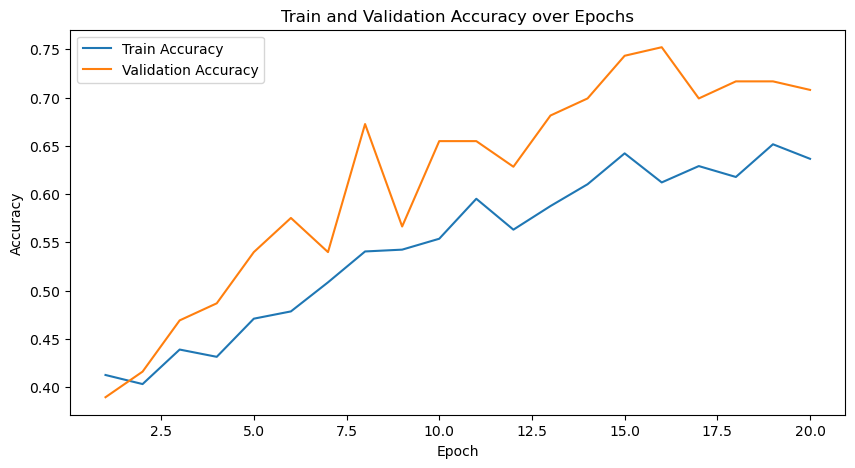

In [190]:
import matplotlib.pyplot as plt

# Plotting Loss
plt.figure(figsize=(10,5))
plt.plot(range(1, 21), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Plotting Train and Validation Accuracy
plt.figure(figsize=(10,5))
plt.plot(range(1, 21), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 21), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy over Epochs')
plt.legend()
plt.show()


## Change hidden_dim number

In [168]:
if __name__ == '__main__':
    # Set fixed random number seed
    torch.manual_seed(420)
    
    # Initialize model, criterion, and optimizer
    input_dim = X_train.shape[1]
    hidden_dim = 33 # change hidden_dim number
    learning_rate = 0.0085
    output_dim = 2
    dropout_rate = 0.05
    model = MLP(input_dim, hidden_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    weight_decay = 0.007
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Initialize a DataFrame to store the results
    results_df = pd.DataFrame(columns=['Epoch', 'Loss', 'Train Accuracy', 'Val Accuracy'])
    
# Run the training loop
train_accuracies, val_accuracies, losses = [], [], []  # Initialize lists
for epoch in range(20):  
    print(f'Starting epoch {epoch+1}')
    
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Add L1 regularization
    l1_reg = torch.tensor(0.).to(X_train_tensor.device)
    for param in model.parameters():
        l1_reg += torch.norm(param, 1)
    loss += l1_regularization_strength * l1_reg
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Store the loss value
    losses.append(loss.item())
    
    # Calculate and store Training Accuracy
    with torch.no_grad():
        _, train_predicted = torch.max(outputs, 1)
        train_accuracy = (train_predicted == y_train_tensor).float().mean().item()
        train_accuracies.append(train_accuracy)
        
        # Calculate and store Validation Accuracy
        val_outputs = model(X_val_tensor)
        _, val_predicted = torch.max(val_outputs, 1)
        val_accuracy = (val_predicted == y_val_tensor).float().mean().item()
        val_accuracies.append(val_accuracy)
        
    # Append the results to the DataFrame
    results_df = pd.concat([results_df, pd.DataFrame({
        'Epoch': [epoch + 1],
        'Loss': [loss.item()],
        'Train Accuracy': [train_accuracy],
        'Val Accuracy': [val_accuracy]
    })], ignore_index=True)
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}, Train Accuracy: {train_accuracy}, Val Accuracy: {val_accuracy}')


Starting epoch 1
Epoch 1, Loss: 0.9172593355178833, Train Accuracy: 0.6007533073425293, Val Accuracy: 0.6371681690216064
Starting epoch 2
Epoch 2, Loss: 0.914556086063385, Train Accuracy: 0.5819209218025208, Val Accuracy: 0.6460176706314087
Starting epoch 3
Epoch 3, Loss: 0.911747395992279, Train Accuracy: 0.6007533073425293, Val Accuracy: 0.6814159154891968
Starting epoch 4
Epoch 4, Loss: 0.904504656791687, Train Accuracy: 0.6214689016342163, Val Accuracy: 0.6371681690216064
Starting epoch 5
Epoch 5, Loss: 0.9083802103996277, Train Accuracy: 0.6158192157745361, Val Accuracy: 0.6194690465927124
Starting epoch 6
Epoch 6, Loss: 0.9063979387283325, Train Accuracy: 0.6195856928825378, Val Accuracy: 0.6460176706314087
Starting epoch 7
Epoch 7, Loss: 0.9080240726470947, Train Accuracy: 0.6064029932022095, Val Accuracy: 0.6725663542747498
Starting epoch 8
Epoch 8, Loss: 0.9023611545562744, Train Accuracy: 0.625235378742218, Val Accuracy: 0.6637167930603027
Starting epoch 9
Epoch 9, Loss: 0.89

## Change leanring rate

In [179]:
if __name__ == '__main__':
    # Set fixed random number seed
    torch.manual_seed(420)
    
    # Initialize model, criterion, and optimizer
    input_dim = X_train.shape[1]
    hidden_dim = 45
    learning_rate = 0.08 # change learning rate
    output_dim = 2
    dropout_rate = 0.05
    model = MLP(input_dim, hidden_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    weight_decay = 0.04
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Initialize a DataFrame to store the results
    results_df = pd.DataFrame(columns=['Epoch', 'Loss', 'Train Accuracy', 'Val Accuracy'])
    
# Run the training loop
train_accuracies, val_accuracies, losses = [], [], []  # Initialize lists
for epoch in range(20):  
    print(f'Starting epoch {epoch+1}')
    
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Add L1 regularization
    l1_reg = torch.tensor(0.).to(X_train_tensor.device)
    for param in model.parameters():
        l1_reg += torch.norm(param, 1)
    loss += l1_regularization_strength * l1_reg
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Store the loss value
    losses.append(loss.item())
    
    # Calculate and store Training Accuracy
    with torch.no_grad():
        _, train_predicted = torch.max(outputs, 1)
        train_accuracy = (train_predicted == y_train_tensor).float().mean().item()
        train_accuracies.append(train_accuracy)
        
        # Calculate and store Validation Accuracy
        val_outputs = model(X_val_tensor)
        _, val_predicted = torch.max(val_outputs, 1)
        val_accuracy = (val_predicted == y_val_tensor).float().mean().item()
        val_accuracies.append(val_accuracy)
        
    # Append the results to the DataFrame
    results_df = pd.concat([results_df, pd.DataFrame({
        'Epoch': [epoch + 1],
        'Loss': [loss.item()],
        'Train Accuracy': [train_accuracy],
        'Val Accuracy': [val_accuracy]
    })], ignore_index=True)
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}, Train Accuracy: {train_accuracy}, Val Accuracy: {val_accuracy}')


Starting epoch 1
Epoch 1, Loss: 0.9986431002616882, Train Accuracy: 0.6365348696708679, Val Accuracy: 0.6902654767036438
Starting epoch 2
Epoch 2, Loss: 0.9818296432495117, Train Accuracy: 0.6440678238868713, Val Accuracy: 0.6902654767036438
Starting epoch 3
Epoch 3, Loss: 0.9755500555038452, Train Accuracy: 0.6553672552108765, Val Accuracy: 0.6991150379180908
Starting epoch 4
Epoch 4, Loss: 0.9666234254837036, Train Accuracy: 0.6534839868545532, Val Accuracy: 0.6991150379180908
Starting epoch 5
Epoch 5, Loss: 0.9583584070205688, Train Accuracy: 0.6553672552108765, Val Accuracy: 0.6991150379180908
Starting epoch 6
Epoch 6, Loss: 0.9520449638366699, Train Accuracy: 0.6534839868545532, Val Accuracy: 0.6991150379180908
Starting epoch 7
Epoch 7, Loss: 0.9479197263717651, Train Accuracy: 0.6553672552108765, Val Accuracy: 0.6991150379180908
Starting epoch 8
Epoch 8, Loss: 0.9423685073852539, Train Accuracy: 0.6553672552108765, Val Accuracy: 0.6991150379180908
Starting epoch 9
Epoch 9, Loss: 

## Change the weight_decay(L2) rate

In [187]:
if __name__ == '__main__':
    # Set fixed random number seed
    torch.manual_seed(420)
    
    # Initialize model, criterion, and optimizer
    input_dim = X_train.shape[1]
    hidden_dim = 45
    learning_rate = 0.0085 
    output_dim = 2
    dropout_rate = 0.005
    model = MLP(input_dim, hidden_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    weight_decay = 0.004 # change weight_decay(L2) rate
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Initialize a DataFrame to store the results
    results_df = pd.DataFrame(columns=['Epoch', 'Loss', 'Train Accuracy', 'Val Accuracy'])
    
# Run the training loop
train_accuracies, val_accuracies, losses = [], [], []  # Initialize lists
for epoch in range(20):  
    print(f'Starting epoch {epoch+1}')
    
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Add L1 regularization
    l1_reg = torch.tensor(0.).to(X_train_tensor.device)
    for param in model.parameters():
        l1_reg += torch.norm(param, 1)
    loss += l1_regularization_strength * l1_reg
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Store the loss value
    losses.append(loss.item())
    
    # Calculate and store Training Accuracy
    with torch.no_grad():
        _, train_predicted = torch.max(outputs, 1)
        train_accuracy = (train_predicted == y_train_tensor).float().mean().item()
        train_accuracies.append(train_accuracy)
        
        # Calculate and store Validation Accuracy
        val_outputs = model(X_val_tensor)
        _, val_predicted = torch.max(val_outputs, 1)
        val_accuracy = (val_predicted == y_val_tensor).float().mean().item()
        val_accuracies.append(val_accuracy)
        
    # Append the results to the DataFrame
    results_df = pd.concat([results_df, pd.DataFrame({
        'Epoch': [epoch + 1],
        'Loss': [loss.item()],
        'Train Accuracy': [train_accuracy],
        'Val Accuracy': [val_accuracy]
    })], ignore_index=True)
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}, Train Accuracy: {train_accuracy}, Val Accuracy: {val_accuracy}')


Starting epoch 1
Epoch 1, Loss: 0.9955587387084961, Train Accuracy: 0.6553672552108765, Val Accuracy: 0.6814159154891968
Starting epoch 2
Epoch 2, Loss: 0.994795560836792, Train Accuracy: 0.6516007781028748, Val Accuracy: 0.6902654767036438
Starting epoch 3
Epoch 3, Loss: 0.9939298629760742, Train Accuracy: 0.6534839868545532, Val Accuracy: 0.6902654767036438
Starting epoch 4
Epoch 4, Loss: 0.9930027723312378, Train Accuracy: 0.6591337323188782, Val Accuracy: 0.6814159154891968
Starting epoch 5
Epoch 5, Loss: 0.9895986318588257, Train Accuracy: 0.6610169410705566, Val Accuracy: 0.6814159154891968
Starting epoch 6
Epoch 6, Loss: 0.989418625831604, Train Accuracy: 0.6534839868545532, Val Accuracy: 0.6902654767036438
Starting epoch 7
Epoch 7, Loss: 0.9882668852806091, Train Accuracy: 0.6534839868545532, Val Accuracy: 0.6991150379180908
Starting epoch 8
Epoch 8, Loss: 0.9876329898834229, Train Accuracy: 0.6553672552108765, Val Accuracy: 0.6902654767036438
Starting epoch 9
Epoch 9, Loss: 0.

# Single layer model Perceptron

In [154]:
# Step 1: Import Necessary Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Step 3: Preprocess the Data
# Handle missing values, encode categorical variables if any, etc.
# For simplicity, we are assuming that the data is clean.

# Step 4: Split the Data into Training and Testing Sets
X_else = dataset.drop('Outcome', axis=1)
y_else = dataset['Outcome']
X_else_train, X_else_test, y_else_train, y_else_test = train_test_split(X_else, y_else, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_else_train = scaler.fit_transform(X_else_train)
X_else_test = scaler.transform(X_else_test)

# Step 5: Implement the Perceptron Algorithm
# Using sklearn's Perceptron implementation
model_single = Perceptron()

# Step 6: Train the Perceptron Model
model_single.fit(X_else_train, y_else_train)

# Step 7: Evaluate the Model
y_pred = model_single.predict(X_else_test)
accuracy = accuracy_score(y_else_test, y_pred)

print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 70.39%


# Mutiple(Three) layers model Perceptron

In [156]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),  # corrected to hidden_dim1
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),  # corrected to hidden_dim1 and hidden_dim2
            nn.ReLU(),
            nn.Linear(hidden_dim2, output_dim)  # corrected to hidden_dim2
        )

        # Initialization
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
        
    def forward(self, x):
        return self.layers(x)


In [162]:
if __name__ == '__main__':
    # Set fixed random number seed
    torch.manual_seed(420)
    
    # Initialize model, criterion, and optimizer
    input_dim = X_train.shape[1]
    hidden_dim1 = 49
    hidden_dim2 = 20
    learning_rate = 0.0085
    output_dim = 2
    dropout_rate = 0.05

    model1 = MLP(input_dim, hidden_dim1, hidden_dim2, output_dim)
    criterion = nn.CrossEntropyLoss()
    weight_decay = 0.005
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Initialize lists to store accuracies and losses
    train_accuracies, val_accuracies, losses = [], [], []
    # Run the training loop
    for epoch in range(20):  # 50 epochs at maximum
        print(f'Starting epoch {epoch+1}')
        
        # Forward pass
        outputs = model1(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Store the loss value
        losses.append(loss.item())
        
        # Calculate and store Training Accuracy
        with torch.no_grad():
            _, train_predicted = torch.max(outputs, 1)
            train_accuracies.append((train_predicted == y_train_tensor).float().mean().item())
            
            # Calculate and store Validation Accuracy
            val_outputs = model(X_val_tensor)
            _, val_predicted = torch.max(val_outputs, 1)
            val_accuracies.append((val_predicted == y_val_tensor).float().mean().item())
        
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Train Accuracy: {train_accuracies[-1]}, Val Accuracy: {val_accuracies[-1]}')
    
    print('Training process has finished.')

Starting epoch 1
Epoch 1, Loss: 0.6689123511314392, Train Accuracy: 0.6704331636428833, Val Accuracy: 0.6991150379180908
Starting epoch 2
Epoch 2, Loss: 0.6689123511314392, Train Accuracy: 0.6704331636428833, Val Accuracy: 0.6991150379180908
Starting epoch 3
Epoch 3, Loss: 0.6689123511314392, Train Accuracy: 0.6704331636428833, Val Accuracy: 0.6991150379180908
Starting epoch 4
Epoch 4, Loss: 0.6689123511314392, Train Accuracy: 0.6704331636428833, Val Accuracy: 0.6991150379180908
Starting epoch 5
Epoch 5, Loss: 0.6689123511314392, Train Accuracy: 0.6704331636428833, Val Accuracy: 0.6991150379180908
Starting epoch 6
Epoch 6, Loss: 0.6689123511314392, Train Accuracy: 0.6704331636428833, Val Accuracy: 0.6991150379180908
Starting epoch 7
Epoch 7, Loss: 0.6689123511314392, Train Accuracy: 0.6704331636428833, Val Accuracy: 0.6991150379180908
Starting epoch 8
Epoch 8, Loss: 0.6689123511314392, Train Accuracy: 0.6704331636428833, Val Accuracy: 0.6991150379180908
Starting epoch 9
Epoch 9, Loss: 